# Check observables given a results file from a TRSL simulation

The purpose of this notebook is to compare some results of the TRSL model against real world observables in order to test the calibration.

We are checking:

1. Protein synthesis rate
2. Ribosome speed
3. Ribosome density
4. x

In [1]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pgf_with_rc_fonts)
%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['patch.edgecolor'] = 'powderblue'
plt.rcParams["patch.force_edgecolor"] = True  # required
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.color']='grey'
plt.rcParams['grid.alpha']='0.5'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['axes.color_cycle'] = ['steelblue', 'darkred', 'darkgreen']

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:915: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
#filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"
#filepath = "../../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1752_3600s.p"
filepath = "../../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20170331_2025_200000_ribosomes_3600s.p"

The following assumes the results file is readable (otherwise replace pypy specifics):

In [4]:
results = pkl.load(open(filepath))

## 1. Protein synthesis rate

In [5]:
init_rates_plotkin = pkl.load(open('../../parameters/init_rates_plotkin.p'))
print len(init_rates_plotkin)

4839


In [6]:
transcriptome_shah = pkl.load(open('../../parameters/transcriptome_shah.p'))
print len(transcriptome_shah)

4839


Exome from SGD (yeastgenome.org)

All yeast ORFs (http://downloads.yeastgenome.org/sequence/S288C_reference/orf_dna/):

ORF Coding Sequences (CDS) only, without 5'-UTR, 3'-UTR, intron sequences, or bases not translated due to translational frameshifting, for all "Verified" and "Uncharacterized" ORFs, and transposable element genes.

Does NOT include sequences for ORFs classified as "Dubious" or "pseudogene".

In [7]:
orf_genomic_dict = pkl.load(open("../../parameters/orf_coding.p"))
len(orf_genomic_dict)

6713

Define protein names in results:

In [8]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein', 
             'peptide_bonds']

for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

print len(protnames)

4475


Some were perhaps not transcribed or translated.

Plot some randomly selected timecourses:

In [9]:
size = 3
protnames_plot = np.array(random.sample(protnames, size * size))
protnames_plot.shape = (size, size)

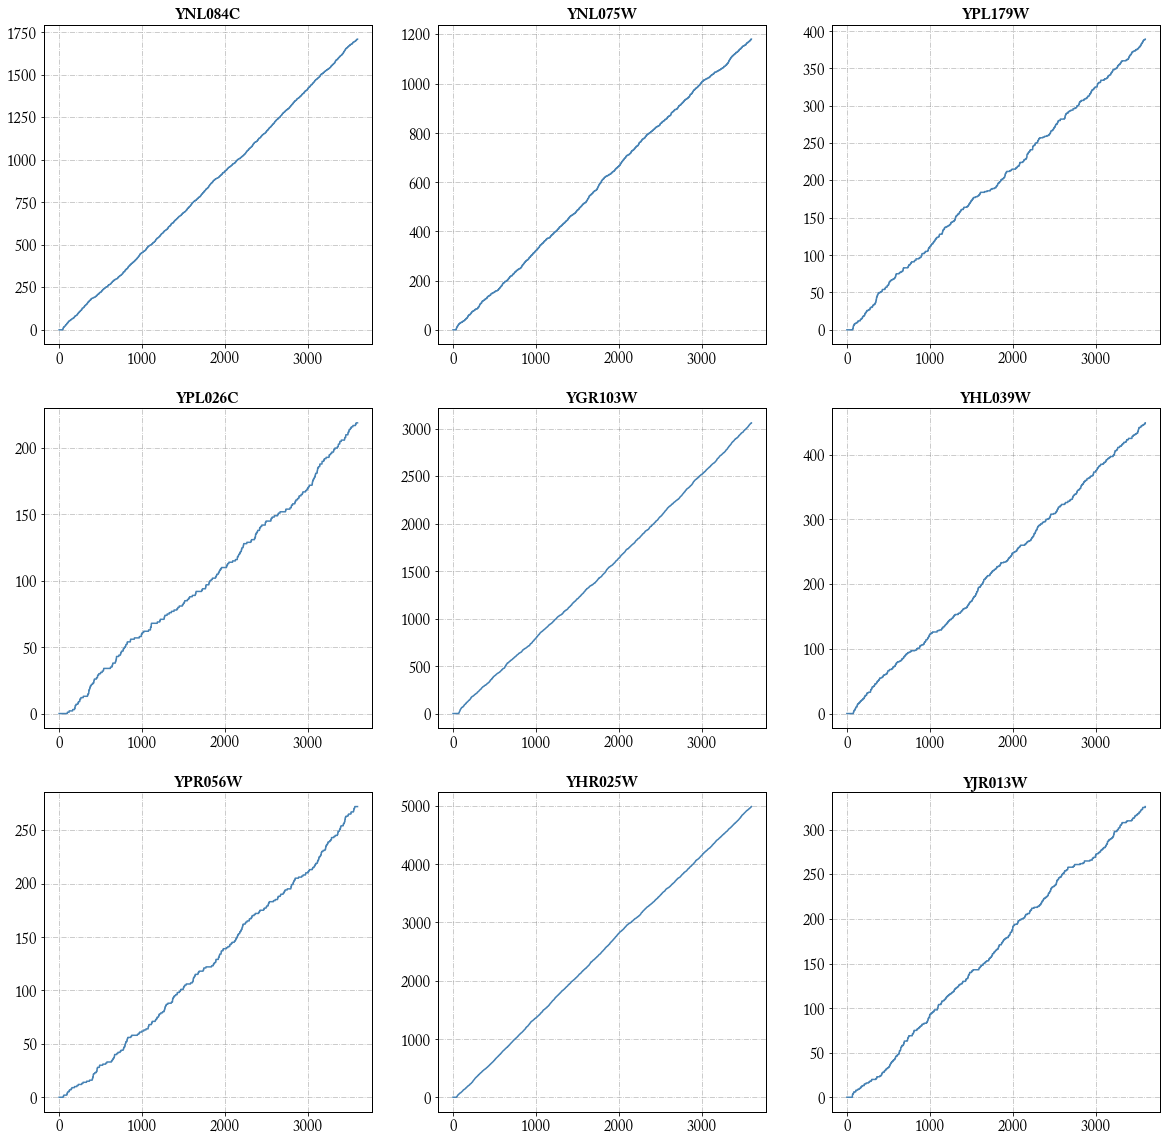

In [10]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))

for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = results['timecourses'][protnames_plot[i][j]]
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 1000.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 15, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)

Do the same by normalizing by transcript abundance:

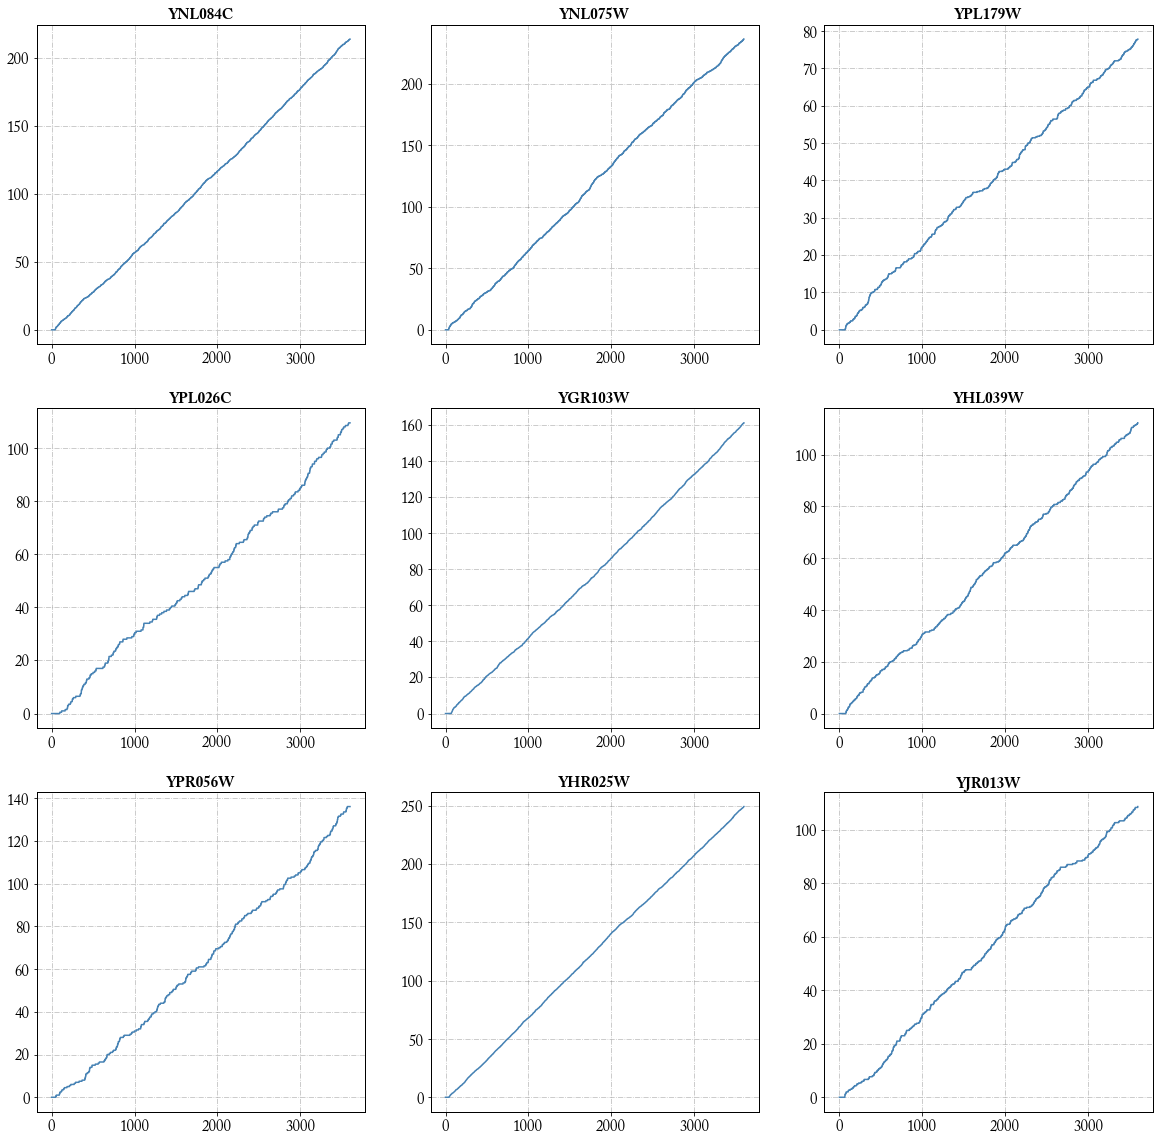

In [11]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = np.array(results['timecourses'][protnames_plot[i][j]])/(1.0*transcriptome_shah[protnames_plot[i][j]])
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 1000.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 15, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)

For each protein, calculate speed of translation (= synthesis rate per cell):

In [12]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 145.73251336288234
YAL038W 123.38209092480422
YJL189W 115.12959770118529
YCR012W 112.47428013107705
YOL086C 117.84700270134138
YLR110C 108.4815219265813
YLR044C 193.92298850580755
YKL152C 115.67130294848134


In [13]:
pd.Series(prot_speeds.values()).describe()

count    4475.000000
mean        1.349305
std         7.847669
min         0.001149
25%         0.049425
50%         0.122989
75%         0.379763
max       193.922989
dtype: float64

Distribution of translation speeds (finished protein molecules per second, every protein is one datapoint):

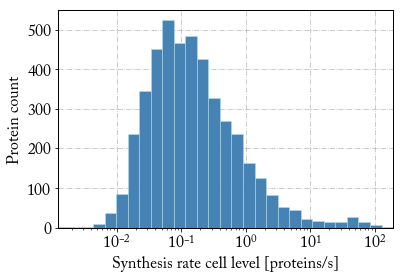

In [14]:
plt.hist(prot_speeds.values(), bins=10**np.linspace(np.log10(min(prot_speeds.values())+0.0001),
                                                    np.log10(max(prot_speeds.values())), 30))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('Synthesis rate cell level [proteins/s]', fontsize=16)
plt.gca().set_ylabel('Protein count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)
plt.show()

Three orders of magnitude. Let us check how much of this is explained by transcript abundance.

Again try the same for proteins normalized by transcript abundance (proteins/transcript/sec):

In [15]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome_shah[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.20: 
        print prot, prot_per_transcript_speeds[prot]

YJL189W 0.20833333333339824
YJL158C 0.22127708489000514
YDR461W 0.23591954022995856
YLR325C 0.20028735632190148
YDR224C 0.2241508132652
YLR061W 0.20057471264374063
YLR388W 0.23132183908053183


In [16]:
pd.Series(prot_per_transcript_speeds).describe()

count    4475.000000
mean        0.046298
std         0.029389
min         0.000575
25%         0.026149
50%         0.039370
75%         0.058621
max         0.235920
dtype: float64

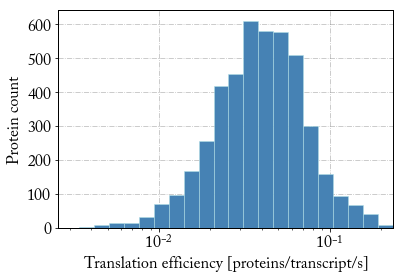

In [17]:
plt.hist(prot_per_transcript_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                              np.log10(max(prot_per_transcript_speeds.values())), 30))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
plt.gca().set_xlabel('Translation efficiency [proteins/transcript/s]', fontsize=16)
plt.gca().set_ylabel('Protein count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)
plt.show()

Only one order of magnitude distribution left after division by transcript abundance.

Measure the 1%-99% range (Weinberg et al. say it is 21-fold, Ingolia 100-fold):

In [18]:
print pd.Series(prot_per_transcript_speeds).quantile(0.01)
print pd.Series(prot_per_transcript_speeds).quantile(0.99)
print pd.Series(prot_per_transcript_speeds).quantile(0.99)/pd.Series(prot_per_transcript_speeds).quantile(0.01)

0.00775906661303
0.158704523249
20.4540740741


Closer to Weinberg et al. The distribution is also asymmetric in a similar way as in Fig. 5A of Weinberg et al.

## 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs.

The following is smaller than 20000 (or 60000), probably because not for every gene in transcriptome_plotkin_20000.p there is an initiation rate available.

In [19]:
len(results['transcriptome'])

57508

In [20]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [21]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) 
                               for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [23]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [24]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [25]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [26]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [27]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [28]:
pd.Series(orf_lengths.values()).describe()

count     6713.000000
mean      1352.414122
std       1139.682772
min         51.000000
25%        534.000000
50%       1077.000000
75%       1767.000000
max      14733.000000
dtype: float64

In [29]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [30]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:940: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


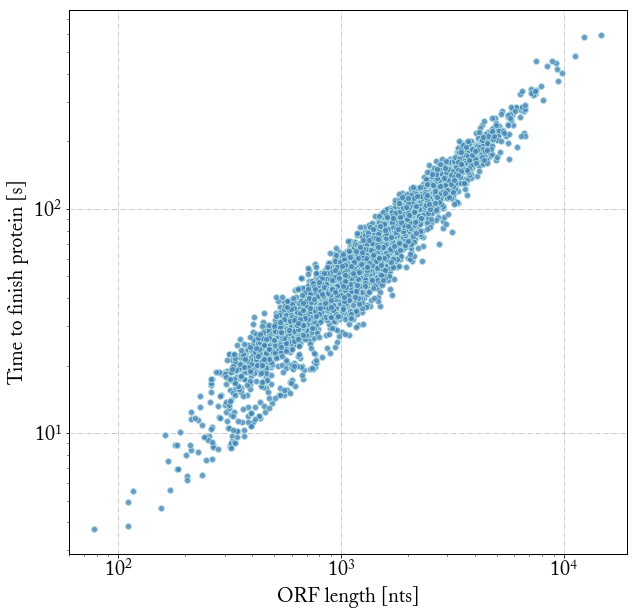

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.8, color=plt.rcParams['axes.color_cycle'][0], 
           edgecolor=plt.rcParams['patch.edgecolor'], linewidth='1')
ax.set_xlabel('ORF length [nts]', fontsize=20)
ax.set_ylabel('Time to finish protein [s]', fontsize=20)
plt.setp(plt.gca().get_xticklabels(), fontsize=20)
plt.setp(plt.gca().get_yticklabels(), fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')

In [32]:
myedgecolor = 'powderblue'
myfacecolor = 'steelblue'

In [33]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, markersize=20,
                  alpha=0.8, figsize=(10, 10), rasterized=True, filename="scatterdict.png"):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure(figsize=figsize)                

    ax = fig.add_subplot(111)
    #ax.set_rasterization_zorder(1)
    
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys,
                       #c=plt.rcParams['axes.color_cycle'][0], 
                       c=myfacecolor, 
                       #edgecolor=plt.rcParams['patch.edgecolor'],
                       edgecolor=myedgecolor,
                       s=markersize, zorder=0)
    scat.set_alpha(alpha)
    #scat.set_color()
    #scat.set_edgecolors(plt.rcParams['patch.edgecolor'])
    # , color=, edgecolor=

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points][:-2]  # modify to remove outliers 
    new_ys = [point[1] for point in sorted_points][:-2]  # modify to remove outliers
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, plt.rcParams['axes.color_cycle'][1], linewidth=4)

    ax.set_rasterization_zorder(1)

    plt.savefig(filename, bbox_inches='tight', dpi=200)

4475


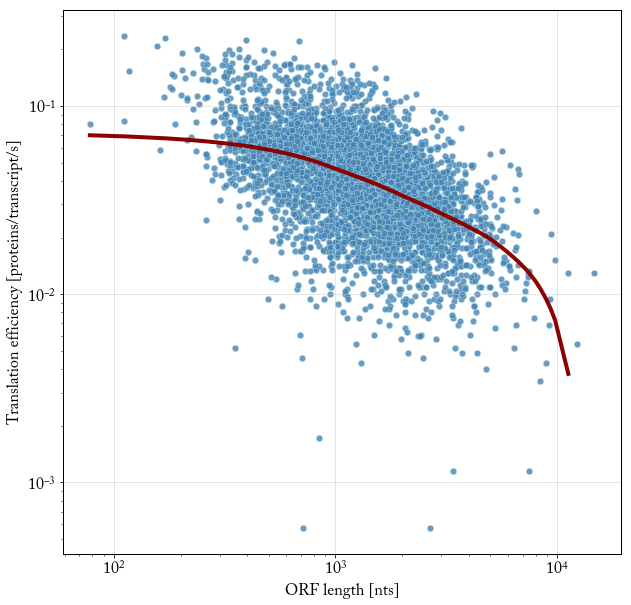

In [42]:
scatter_dicts(orf_lengths, prot_per_transcript_speeds, xaxislabel='ORF length [nts]', 
              yaxislabel='Translation efficiency [proteins/transcript/s]', fontsize=16, markersize=40,
              alpha=0.8, filename='translation_efficiency_vs_ORF_length.pgf')

Longer transcripts are translated less efficiently than shorter transcripts. (Reason?)

4716


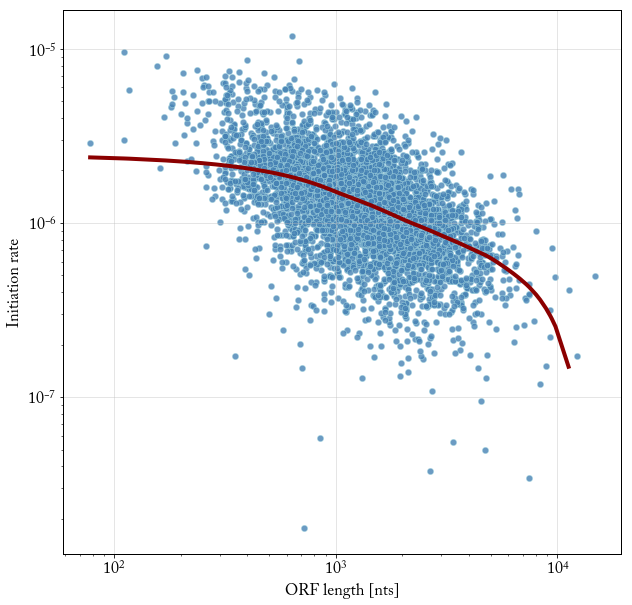

In [35]:
scatter_dicts(orf_lengths, init_rates_plotkin, xaxislabel='ORF length [nts]', 
              yaxislabel='Initiation rate', fontsize=16, markersize=40, alpha=0.8,
             filename=None)

4475


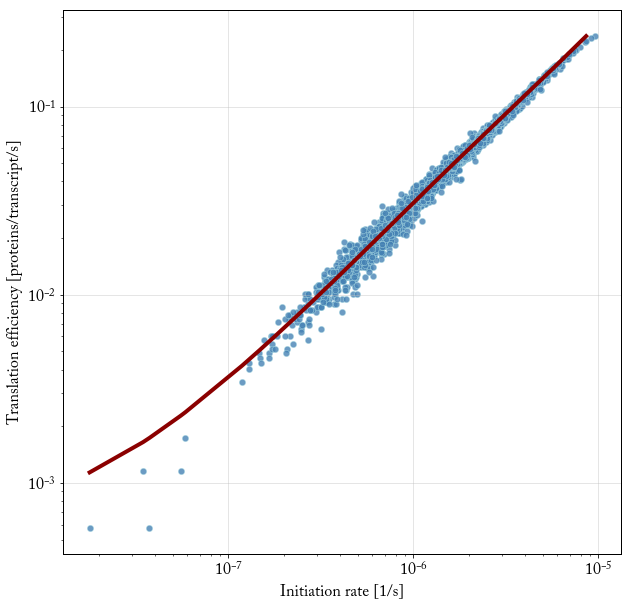

In [36]:
scatter_dicts(init_rates_plotkin, prot_per_transcript_speeds, xaxislabel='Initiation rate [1/s]', 
              yaxislabel='Translation efficiency [proteins/transcript/s]', fontsize=16, markersize=40,
              alpha=0.8, rasterized=True, filename='initiation_rate_vs_prot_per_transcript_speeds.pgf')

Next to each other:

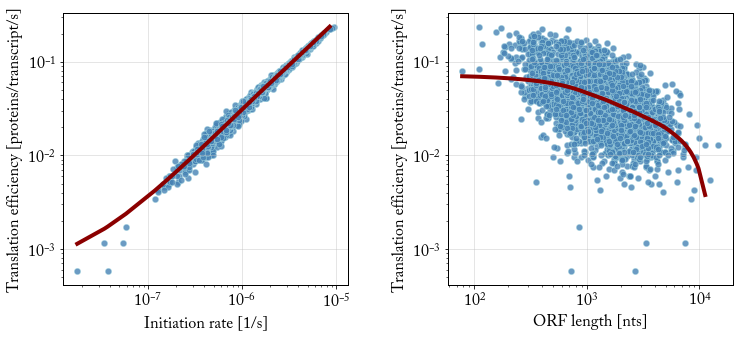

In [43]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)

dict1 = init_rates_plotkin
dict2 = prot_per_transcript_speeds
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translation efficiency [proteins/transcript/s]'
fontsize = 16
markersize = 40
alpha=0.8
rasterized=True,
    
#ax.set_rasterization_zorder(1)

plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
if yaxislabel:
    ax.set_ylabel(yaxislabel)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

scat = plt.scatter(xs, ys,
                   #c=plt.rcParams['axes.color_cycle'][0], 
                   c=myfacecolor, 
                   #edgecolor=plt.rcParams['patch.edgecolor'],
                   edgecolor=myedgecolor,
                   s=markersize, zorder=0)
scat.set_alpha(alpha)
#scat.set_color()
#scat.set_edgecolors(plt.rcParams['patch.edgecolor'])
# , color=, edgecolor=

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points][:-2]  # modify to remove outliers 
new_ys = [point[1] for point in sorted_points][:-2]  # modify to remove outliers
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, plt.rcParams['axes.color_cycle'][1], linewidth=4)

ax.set_rasterization_zorder(1)

#ax.set_xlabel('ORF length [nts]', fontsize=16)
#ax.set_ylabel('Time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

#plt.text(1.1, 1000, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)

dict1 = orf_lengths
dict2 = prot_per_transcript_speeds
xaxislabel = 'ORF length [nts]'
yaxislabel = 'Translation efficiency [proteins/transcript/s]'
fontsize = 16
markersize = 40
alpha=0.8
rasterized=True,
    
#ax.set_rasterization_zorder(1)

plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
if yaxislabel:
    ax.set_ylabel(yaxislabel)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

scat = plt.scatter(xs, ys,
                   #c=plt.rcParams['axes.color_cycle'][0], 
                   c=myfacecolor, 
                   #edgecolor=plt.rcParams['patch.edgecolor'],
                   edgecolor=myedgecolor,
                   s=markersize, zorder=0)
scat.set_alpha(alpha)
#scat.set_color()
#scat.set_edgecolors(plt.rcParams['patch.edgecolor'])
# , color=, edgecolor=

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points][:-2]  # modify to remove outliers 
new_ys = [point[1] for point in sorted_points][:-2]  # modify to remove outliers
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, plt.rcParams['axes.color_cycle'][1], linewidth=4)

ax.set_rasterization_zorder(1)

#ax.set_xlabel('ORF length [nts]', fontsize=16)
#ax.set_ylabel('Time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

#plt.text(1.1, 1000, "A", fontsize=16, weight="bold")

#plt.text(1.5, 900, "B", fontsize=16, weight="bold")
#plt.title("") #, weight="bold")
#ax.text(.5, .82, 'Ribosome speed\ndistribution', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.savefig('limiting_initiation_rates.pgf', bbox_inches='tight', dpi=300)

## 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

In [38]:
import shelve

#filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"
#filepath = "../../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1753.db"
filepath = "../../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20170331_2025.db"
d = shelve.open(filepath, flag='r')

Populate a dictionary with ribosome "lattices":

In [39]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

First we plot the ribosome densities per gene:

In [40]:
ribo_density_per_100nt_dict = {key: sum(ribo_lattice_dict[key]) * 100.0 / 3.0 / len(ribo_lattice_dict[key]) / 
                               transcriptome_shah[key] for key in ribo_lattice_dict}

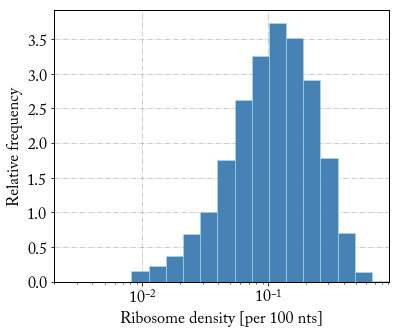

In [41]:
fig = plt.figure(figsize=(6, 5))

plt.hist(ribo_density_per_100nt_dict.values(), 
         bins = 10**np.linspace(np.log10(min(ribo_density_per_100nt_dict.values())+0.0001), 
                                np.log10(max(ribo_density_per_100nt_dict.values())), 30), normed=True)
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(ribo_density_per_100nt_dict.values())+0.002, max(ribo_density_per_100nt_dict.values())])
plt.gca().set_xlabel('Ribosome density [per 100 nts]', fontsize=16)
plt.gca().set_ylabel('Relative frequency', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.savefig('ribosome_density.pgf', bbox_inches='tight')